In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import datetime
import requests
from tqdm import tqdm

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.tsatools import add_trend
import statsmodels.api as sm
import holidays

from watermark import watermark

print(watermark())

Last updated: 2024-09-11T20:28:21.127393+03:00

Python implementation: CPython
Python version       : 3.12.6
IPython version      : 8.21.0

Compiler    : GCC 14.2.1 20240817
OS          : Linux
Release     : 6.10.7-gentoo
Machine     : x86_64
Processor   : AMD Ryzen 9 5950X 16-Core Processor
CPU cores   : 32
Architecture: 64bit



## Загрузка данных

In [2]:
time_history_url = "https://deepstatemap.live/api/history/public"

In [3]:
# Making a get request
response = requests.get(time_history_url)

df = pd.DataFrame()
# print json content
t = len(response.json())
Path("data/").mkdir(exist_ok=True)
with tqdm(total=t) as pbar:
    for n, i in enumerate(response.json()):
        timestamp = i["id"]
        time_index = datetime.datetime.fromtimestamp(timestamp)
        pbar.set_description(str(time_index.date()), refresh=True)
        area = requests.get(
            f"https://deepstatemap.live/api/history/{timestamp}/areas")
        js_df = pd.json_normalize(area.json()).assign(time_index=time_index)
        df = pd.concat([df, js_df], ignore_index=True)
        pbar.update(1)
df

2024-09-10: 100%|██████████| 1036/1036 [05:03<00:00,  3.41it/s]


,hash,area,percent,type,time_index
0,#a52714,63864.643990,10.579,occupied_after_24_02_2022,2022-04-03 15:33:28
1,#880e4f,46937.208199,7.775,occupied_to_24_02_2022,2022-04-03 15:33:28
2,#bcaaa4,5587.522472,0.926,unspecified,2022-04-03 15:33:28
3,#0f9d58,14012.882652,2.321,liberated,2022-04-03 15:33:28
4,#a52714,63864.643990,10.579,occupied_after_24_02_2022,2022-04-03 19:46:15
...,...,...,...,...,...
5317,#ff5252,139991.513798,23.189,other_territories,2024-09-10 23:59:06
5318,#880e4f,43974.128584,7.284,occupied_to_24_02_2022,2024-09-10 23:59:06
5319,#a52714,65936.863690,10.922,occupied_after_24_02_2022,2024-09-10 23:59:06
5320,#bdbdbd,337.618695,0.056,other_territories,2024-09-10 23:59:06


In [4]:
df.set_index("time_index", inplace=True)
df = df.astype(
    {"percent": "float32", "area": "float64", "hash": "string", "type": "category"}
)

In [5]:
df.to_csv(Path("data/area_history.csv"))

# Моделирование краткосрочного момента


In [6]:
try:
    df
except NameError:
    df = None
if df is None:
    td = (
        datetime.datetime.now().timestamp()
        - Path("data/area_history.csv").stat().st_ctime
    )
    if td >= 60 * 60 * 24:
        print("Данные устарели!")
    df = pd.read_csv(
        Path("data/area_history.csv"),
        index_col="time_index",
        parse_dates=True,
        dtype={
            "percent": "float32",
            "area": "float64",
            "hash": "string",
            "type": "category",
        },
    )

In [7]:
df

,hash,area,percent,type
time_index,,,,
2022-04-03 15:33:28,#a52714,63864.643990,10.579000,occupied_after_24_02_2022
2022-04-03 15:33:28,#880e4f,46937.208199,7.775000,occupied_to_24_02_2022
2022-04-03 15:33:28,#bcaaa4,5587.522472,0.926000,unspecified
2022-04-03 15:33:28,#0f9d58,14012.882652,2.321000,liberated
2022-04-03 19:46:15,#a52714,63864.643990,10.579000,occupied_after_24_02_2022
...,...,...,...,...
2024-09-10 23:59:06,#ff5252,139991.513798,23.188999,other_territories
2024-09-10 23:59:06,#880e4f,43974.128584,7.284000,occupied_to_24_02_2022
2024-09-10 23:59:06,#a52714,65936.863690,10.922000,occupied_after_24_02_2022


In [8]:
area_dinamic = (
    df.dropna()
    .groupby([pd.Grouper(freq="D"), "type"])[["area", "percent"]]
    .mean()
    .reset_index()
    .set_index("time_index")
)
last_date = df.index.max().strftime("%Y-%m-%d %X")

/tmp/ipykernel_5016/3457041684.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([pd.Grouper(freq="D"), "type"])[["area", "percent"]]


In [9]:
occupied_by_ua = (
    df[
        (df["type"] == "other_territories") &
        (df['hash'] == '#01579b')
    ]
    .groupby(pd.Grouper(freq="D"))[["area", "percent"]]
    .mean()
)
occupied_by_ua

,area,percent
time_index,,
2024-08-08,142.989574,0.024
2024-08-09,142.989574,0.024
2024-08-10,142.989574,0.024
2024-08-11,142.989574,0.024
2024-08-12,313.306949,0.052
2024-08-13,313.483165,0.052
2024-08-14,469.022292,0.078
2024-08-15,507.762966,0.084
2024-08-16,532.395801,0.088


In [10]:
area_dinamic.dropna(inplace=True)
area_dinamic["type"]

time_index
2022-04-03                    liberated
2022-04-03    occupied_after_24_02_2022
2022-04-03       occupied_to_24_02_2022
2022-04-03                  unspecified
2022-04-04                    liberated
                        ...            
2024-09-10                    liberated
2024-09-10    occupied_after_24_02_2022
2024-09-10       occupied_to_24_02_2022
2024-09-10            other_territories
2024-09-10                  unspecified
Name: type, Length: 4034, dtype: category
Categories (5, object): ['liberated', 'occupied_after_24_02_2022', 'occupied_to_24_02_2022', 'other_territories', 'unspecified']

In [11]:
area_dinamic["type"].unique()

['liberated', 'occupied_after_24_02_2022', 'occupied_to_24_02_2022', 'unspecified', 'other_territories']
Categories (5, object): ['liberated', 'occupied_after_24_02_2022', 'occupied_to_24_02_2022', 'other_territories', 'unspecified']

In [12]:
ru_holidays = holidays.country_holidays("RU")
ua_holidays = holidays.country_holidays("UA")

In [13]:
target_area = 118370
svo_end = pd.to_datetime("2026-11-15")

In [14]:
aa = area_dinamic[area_dinamic["type"] == "occupied_after_24_02_2022"][
    "area"
]  # ["percent"]
aa = pd.DataFrame(
    index=pd.date_range(start=aa.index.min(), end=aa.index.max(), freq="D")
).join(aa)
aa.interpolate(inplace=True)
aa["prefix"] = 0
aa.loc[:"2022-11-11", "prefix"] = 1
aa

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-09-06,65909.248138,0
2024-09-07,65917.574948,0
2024-09-08,65922.549367,0
2024-09-09,65928.305514,0


In [15]:
aa['area'] = aa['area'].subtract(occupied_by_ua['area'], fill_value=0)
aa

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-09-06,65001.638566,0
2024-09-07,65009.965375,0
2024-09-08,65014.939794,0
2024-09-09,65020.695941,0


In [16]:
best_ff = None
best_aic = 99e99
for order in range(1, 3):
    for period in np.linspace(order * 2, 2 * 365.25, 100):
        fourier_gen = Fourier(period, order)
        ff = fourier_gen.in_sample(aa.index)
        ff["prefix"] = aa["prefix"]
        ff = add_trend(ff, "ct")
        model = sm.OLS(aa["area"], ff).fit()
        if best_ff is None or best_aic > model.aic:
            best_ff = model
best_ff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   area   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     761.7
Date:                Wed, 11 Sep 2024   Prob (F-statistic):               0.00
Time:                        20:33:28   Log-Likelihood:                -8180.8
No. Observations:                 892   AIC:                         1.638e+04
Df Residuals:                     885   BIC:                         1.641e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sin(1,730.50)   872.7686    137.226      6.360      0.000     603.442    1142.095
cos(1,730.50)  2723.7765    210.181     12.959      0.000    2311.264    3136.289
sin(2,730.50)  2325.5057    132.058     17.610      0.000    2066.322    2584.690
cos(2,730.50)  -604.1500    129.985     -4.648      0.000    -859.265    -349.035
prefix         3015.2408    599.927      5.026      0.000    1837.795    4192.686
const           7.18e+04    508.861    141.102      0.000    7.08e+04    7.28e+04
trend           -12.2864      0.884    -13.892      0.000     -14.022     -10.551
==============================================================================
Omnibus:                      339.974   Durbin-Watson:                   0.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2604.540
Skew:                          -1.533   Prob(JB):                         0.00
Kurtosis:                      10.789   Cond. No.                     5.29e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Axes: >

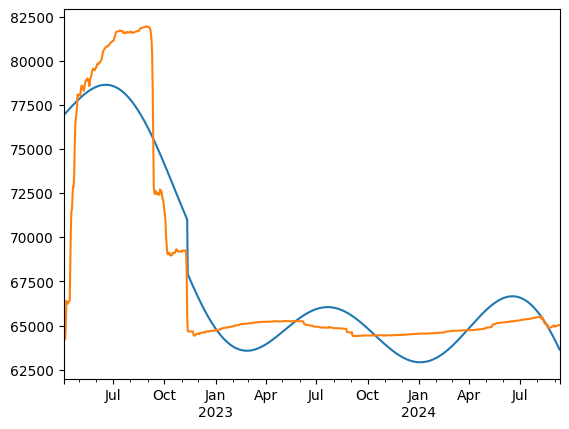

In [17]:
best_ff.predict(ff).plot()
aa["area"].plot()

In [18]:
aa.loc["2022-02-03":]

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-09-06,65001.638566,0
2024-09-07,65009.965375,0
2024-09-08,65014.939794,0
2024-09-09,65020.695941,0


In [19]:
xx = (
    pd.DataFrame(index=aa.index).assign(
        ru_holiday=lambda x: [d in ru_holidays for d in x.index],
        ua_holiday=lambda x: [d in ua_holidays for d in x.index],
    )
).astype("int")

xx = add_trend(xx, "ct")
xx

,ru_holiday,ua_holiday,const,trend
2022-04-03,0,0,1.0,1.0
2022-04-04,0,0,1.0,2.0
2022-04-05,0,0,1.0,3.0
2022-04-06,0,0,1.0,4.0
2022-04-07,0,0,1.0,5.0
...,...,...,...,...
2024-09-06,0,0,1.0,888.0
2024-09-07,0,0,1.0,889.0
2024-09-08,0,0,1.0,890.0
2024-09-09,0,0,1.0,891.0


In [20]:
best_model = None
for p in range(6):
    for q in range(6):
        mod = ARIMA(aa["area"], order=(p, 1, q)).fit()
        if best_model is None or best_model.aic > mod.aic:
            best_model = mod
best_model.summary()

/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv/myds312/lib/python3.12/site-packag

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   area   No. Observations:                  892
Model:                 ARIMA(4, 1, 5)   Log Likelihood               -5828.701
Date:                Wed, 11 Sep 2024   AIC                          11677.402
Time:                        20:33:38   BIC                          11725.325
Sample:                    04-03-2022   HQIC                         11695.718
                         - 09-10-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2758      0.051     25.106      0.000       1.176       1.375
ar.L2         -1.2671      0.059    -21.484      0.000      -1.383      -1.152
ar.L3          0.9850      0.063     15.608      0.000       0.861       1.109
ar.L4         -0.0212      0.047     -0.447      0.655      -0.114       0.072
ma.L1         -0.5226      0.050    -10.424      0.000      -0.621      -0.424
ma.L2          0.6384      0.030     21.164      0.000       0.579       0.698
ma.L3         -0.3818      0.036    -10.532      0.000      -0.453      -0.311
ma.L4         -0.2878      0.019    -15.345      0.000      -0.325      -0.251
ma.L5         -0.2981      0.029    -10.347      0.000      -0.355      -0.242
sigma2      2.539e+04    346.546     73.265      0.000    2.47e+04    2.61e+04
===================================================================================
Ljung-Box (L1) (Q):                   4.92   Jarque-Bera (JB):            136430.98
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.01   Skew:                            -2.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        63.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
fh = 120  # int(365.25 * 5)
fcst = best_model.get_forecast(fh, alpha=0.05).summary_frame()
fcst.index = pd.date_range(
    start=aa.index.max() + pd.DateOffset(days=1), periods=fcst.shape[0], freq="D"
)
fcst

/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


area,mean,mean_se,mean_ci_lower,mean_ci_upper
2024-09-11,65029.019416,159.341492,64716.715830,65341.323003
2024-09-12,65023.786361,321.601298,64393.459400,65654.113321
2024-09-13,65023.210538,462.421807,64116.880451,65929.540626
2024-09-14,65027.344867,576.242317,63897.930679,66156.759056
2024-09-15,65026.156493,679.713796,63693.941932,66358.371054
...,...,...,...,...
2025-01-04,64937.448171,6786.578183,51635.999353,78238.896989
2025-01-05,64937.495226,6830.935579,51549.107510,78325.882942
2025-01-06,64938.510193,6875.206930,51463.352224,78413.668161
2025-01-07,64938.303990,6919.537830,51376.259053,78500.348927


In [22]:
svo_end_alpha = 99.95
svo_end_km_ration = 0.01
hh = fcst[["mean", "mean_se"]].diff() / fcst[["mean", "mean_se"]].abs()
end_svo = hh[
    (hh["mean_se"] <= 1 - svo_end_alpha /
     100) & (hh["mean"] <= svo_end_km_ration / 100)
].index.min()
fcst = fcst[:end_svo]
# fh = fcst.shape[0]
fh = 90

In [23]:
aa

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-09-06,65001.638566,0
2024-09-07,65009.965375,0
2024-09-08,65014.939794,0
2024-09-09,65020.695941,0


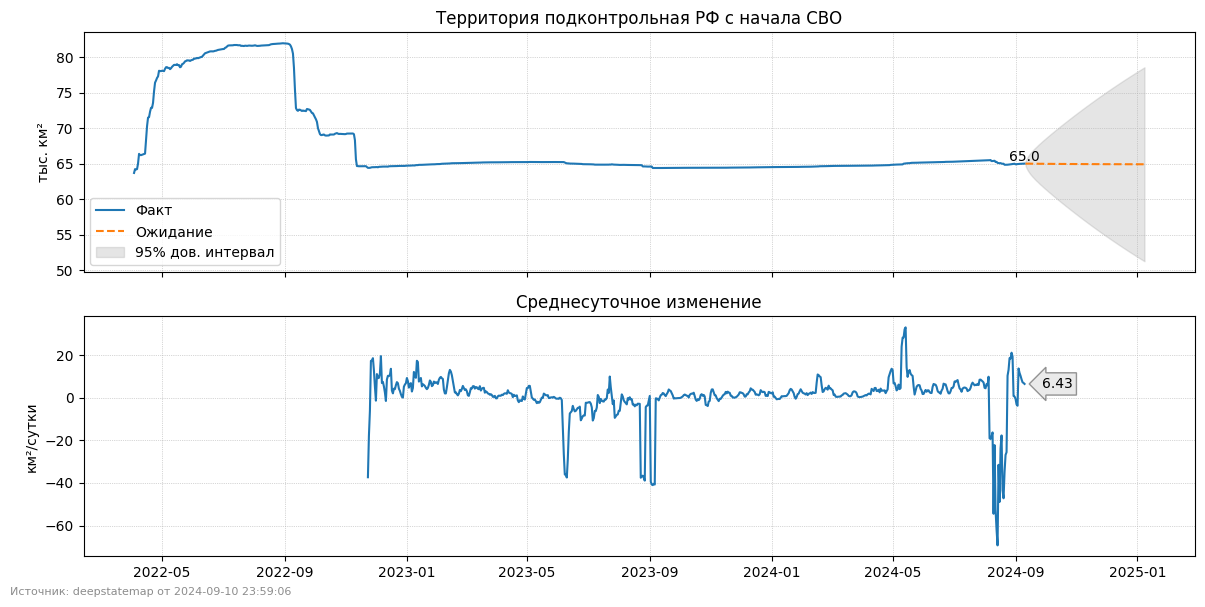

In [24]:
# sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
ax = axs[0]
sns.lineplot(aa["area"] / 1000, ax=ax, label="Факт")
sns.lineplot(fcst["mean"] / 1000, ls="--", ax=ax, label="Ожидание")
fill_95p = ax.fill_between(
    fcst.index,
    fcst["mean_ci_lower"] / 1000,
    fcst["mean_ci_upper"] / 1000,
    alpha=0.2,
    color="grey",
)
fill_95p.set_label("95% дов. интервал")
ax.legend()
ax.set(
    xlabel=None,
    ylabel="тыс. км\u00b2",
    title="Территория подконтрольная РФ с начала СВО",
)
ax.text(aa['area'].index.max(), aa['area'].iloc[-1] /
        1000, f'{aa['area'].iloc[-1]/1000:.1f}', ha='center', va='bottom')
ax = axs[1]
ax.set(
    xlabel=None,
    ylabel="км\u00b2/сутки",
    title="Среднесуточное изменение",
)
day_din_area = (
    aa.diff()["2022-11-23":].rolling(5, center=True,
                                     min_periods=int(5 / 2)).mean()
)
sns.lineplot(
    day_din_area["area"],
    ax=ax,
    legend=None,
)
bbox = dict(boxstyle="larrow", fc="0.8", alpha=0.4)
dy = day_din_area.iloc[-1].values[0]
dx = day_din_area.index.max()
ax.annotate(
    f"{dy:.2f}",
    (dx + datetime.timedelta(days=16 + int(fh / 60)), dy),
    # xytext=(-2, 1),
    bbox=bbox,
    va="center",
    ha="left",
)
for ax in axs:
    ax.grid(ls=":", lw=0.5)
fig.tight_layout()
fig.text(
    0,
    0,
    f"Источник: deepstatemap от {last_date}",
    fontdict={"size": 8},
    alpha=0.45,
)
Path("img/").mkdir(exist_ok=True)
fig.savefig(Path("img/area.png"), format="png", dpi=300)